# Running TARDIS with a custom packet source

In [1]:
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/home/isaac/anaconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/isaac/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:49)


Custom packet source class that is derived from BasePacketSource. The method create_packets (which returns ```nus, mus, energies```) has to be defined.

In [3]:
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.rng = np.random.default_rng(seed=seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets, rng,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """

        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets, self.rng)
        energies = self.create_uniform_packet_energies(no_of_packets, self.rng)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size, self.rng)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size, self.rng
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return nus, mus, energies

In [4]:
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:87)
[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/isaac/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:35)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
 (warnings.py:110)
[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:172)
[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:178)
[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis

[py.warnings         ][WARNING]  /home/isaac/tardis-sn/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../tardis/montecarlo/montecarlo_numba/r_packet.py", line 254:
@njit(**njit_dict)
def get_inverse_doppler_factor(r, mu, time_explosion):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)
[py.warnings         ][WARNING]  /home/isaac/tardis-sn/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

[py.warnings         ][WARNING]  /home/isaac/tardis-sn/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../tardis/montecarlo/montecarlo_numba/r_packet.py", line 614:
@njit(**njit_dict)
def angle_aberration_LF_to_CMF(r_packet, time_explosion, mu):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)
[py.warnings         ][WARNING]  /home/isaac/tardis-sn/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics fo

[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.36964e+42 erg / s Luminosity absorbed = 2.68036e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9895.927775  9349.055054  0.939561  0.721569
	5      10131.973029  9663.682479  0.347876  0.257827
	10     10080.623924  9589.858001  0.203897  0.153798
	15      9866.950689  9346.844370  0.148152  0.113489

 (base.py:436)
[tardis.simulation.base][INFO   ]  t_inne

[tardis.simulation.base][INFO   ]  t_inner 10166.590 K -- next t_inner 11127.546 K (base.py:439)
[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.25013e+43 erg / s Luminosity absorbed = 4.18782e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9446.987155   9883.108451  0.733896  0.892881
	5      9666.414290  10149.038463  0.270056  0.324678
	10     9555.934436  10127.411704  0.163842  0.185648
	15     9352.

[tardis.simulation.base][INFO   ]  t_inner 10992.745 K -- next t_inner 10316.061 K (base.py:439)
[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.33198e+42 erg / s Luminosity absorbed = 3.00717e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9803.376069  9488.891720  0.860173  0.764424
	5      10005.414968  9760.387430  0.325750  0.276406
	10     10052.112445  9685.754561  0.184829  0.164643
	15      9787

[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11615.344313  10549.514128  0.497714  0.443441
	5      11729.411389  10919.073481  0.199205  0.162199
	10     11517.190317  10697.303300  0.123849  0.101289
	15     11103.373456  10379.863073  0.093930  0.075372

 (base.py:436)
[tardis.simulation.base][INFO   ]  t_inner 10014.843 K -- next t_inner 11328.210 K (base.py:439)
[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34741e+43 erg / s Luminosity absorbed = 4.44727e+42 erg

[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10570.856509  11533.554419  0.445926  0.494814
	5      10957.336276  11764.967895  0.162837  0.189464
	10     10916.410391  11444.191999  0.096229  0.121150
	15     10441.053929  11084.736033  0.075026  0.090825

 (base.py:436)
[tardis.simulation.base][INFO   ]  t_inner 11233.248 K -- next t_inner 10123.784 K (base.py:439)
[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.69244e+42 erg / s Luminosity absorbed = 2.74548e+42 er

[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11404.686443  10732.832306  0.497739  0.444436
	5      11664.227712  11084.302807  0.189070  0.162591
	10     11444.220669  10899.736539  0.117732  0.099122
	15     11052.698087  10465.941519  0.089141  0.077378

 (base.py:436)
[tardis.simulation.base][INFO   ]  t_inner 10190.841 K -- next t_inner 11136.097 K (base.py:439)
[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:326)
[py.warnings         ][WARNING]  /home/isaac/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.26319e+43 erg / s Luminosity absorbed = 4.10706e+42 er

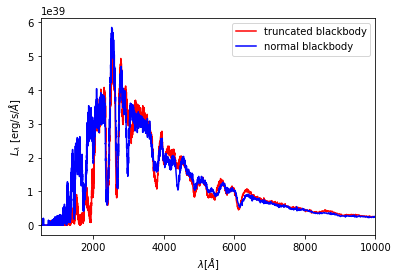

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()